In [1]:
import deorbit
import numpy as np
import matplotlib.pyplot as plt
from deorbit.observer import Observer
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.plotting import plot_trajectories, plot_height
from tqdm import tqdm

This example notebook exists to demonstrate the functionality included within the observer module. The observer class can be initialised for a 2D or 3D scenario and with a given number of radars with appropriate number of radar locations. If no radar locations are inputted then the radars will be spread evenly across the problem space. 

In [2]:
#initialising observer class with sim data
radar_positions = np.array([0.4, 3, 5.6]) #longitude range from 0 to 2pi in 2D scenario
obs = Observer(number_of_radars=3, dim=2, positions_of_radars = radar_positions)

We can see how the radars are aranged through the __plot_config()__ function. If positions are not known then they can be accessed through the __position_of_radars__ attribute.

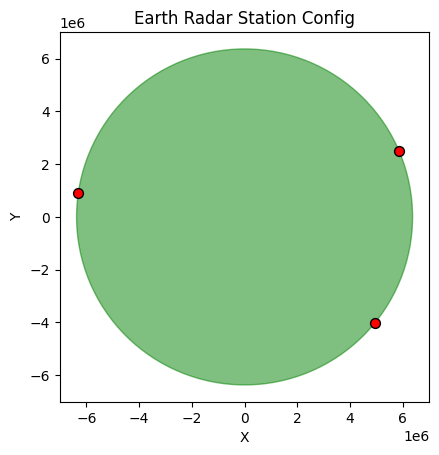

In [3]:
obs.plot_config()

#print(obs.positions_of_radars) access radar positions

For the radar module to make observations the simulator first needs to be ran.

In [4]:
# Running simulator
save_path = "eg/example_2D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


The observer takes the states and their times from the simulator as well as the checking_interval which gives a baseline on the frequency of measurements to be taken.

In [5]:
sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)#checks wether the satellite is in LOS every 100 time steps

We can then see the location of the measurements by through the plotting function. Each measurement has an variance of 0.1 per m unless stated differently within the initialisation.

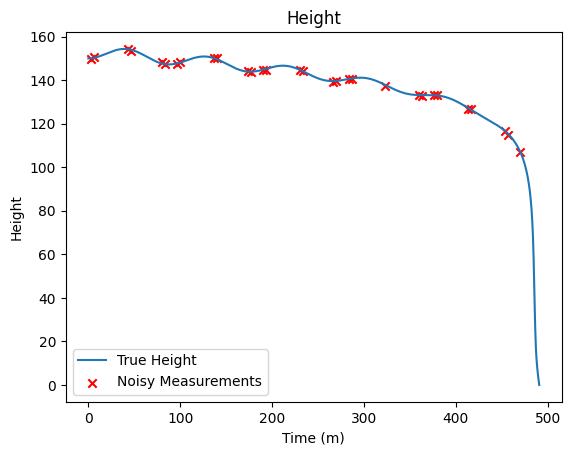

In [7]:
obs_states = obs.observed_states
obs_times = obs.observed_times
traj = sim_states[:, :2]


plot_height(traj, sim_times, observations=obs_states, observation_times = obs_times)

#plot this graph or trajectory graph??

To investigate how the number of radars effects the satellites visibilty, i.e. the number of measurements that can be taken we cna perform this with varying numbers of radar stations.

In [10]:
radar_list = np.arange(1, 30)
satellite_visibility = []
for i in tqdm(radar_list):
    obs = Observer(number_of_radars=i)

    obs.run(sim_states, sim_data.times, checking_interval=10)

    observation_times = obs.observed_times

    satellite_visibility.append((len(observation_times)/len(sim_data.times))*100)


100%|██████████| 29/29 [00:09<00:00,  3.03it/s]


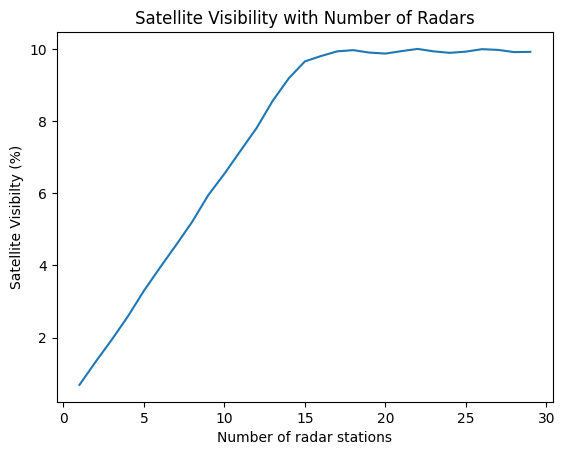

In [9]:
fig, ax = plt.subplots()

ax.plot(radar_list, satellite_visibility)
ax.set_title('Satellite Visibility with Number of Radars')
ax.set_xlabel('Number of radar stations')
ax.set_ylabel('Satellite Visibilty (%)')
plt.show()

#should plateau to 10% so looks good

Here we can see that as the number of radar stations increases the satellite is visible 10 percent of the simulated time, as expected due to the checking interval of 10.